# Toxic Content Classification - Hybrid ML Model


## Objective
Build a **Hybrid Classification System** combining Rule-based Filter + Naive Bayes ML Model.


### Pipeline Architecture:
```
[Input Text]
     ↓
[Text Preprocessing & Cleaning]
     ↓
[Rule-based Filter] (ToxicPhraseDetector)
     ↓
[If toxic phrases detected] → [VIOLATION]
     ↓ (No toxic phrases)
[Naive Bayes ML Model] → Predict probability
     ↓
[If prob > threshold] → [VIOLATION]
     ↓
[Else] → [SAFE]
```


### Features:
- **Rule-based Filter**: Detects known toxic phrases from slang dictionary
- **ML Model**: Naive Bayes (Multinomial + ComplementNB) with hyperparameter tuning
- **Dataset**: `Only_Model/train.csv` (Jigsaw Toxic Comment Challenge with toxic/severe/obscene/threat/insult/identity_hate flags)
- **Binary Classification**: Safe (0) vs Violation (any toxic flag = 1)

## 1. Environment Setup & Imports

In [72]:
# Install required packages (uncomment if needed)
!pip install pandas numpy scikit-learn matplotlib seaborn nltk imbalanced-learn

In [73]:
# Install tokenizers library for BPE
!pip install tokenizers

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
from pathlib import Path
import sys

# Text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Byte-level BPE Tokenizer
from tokenizers import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing

# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Naive Bayes models
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB

# Model evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)

# Imbalanced data handling
from imblearn.over_sampling import SMOTE

# Save model
import joblib
import pickle

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


In [75]:
# Download NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
print("✓ NLTK data downloaded")

✓ NLTK data downloaded


## 2. Import Rule-based ToxicPhraseDetector

In [76]:
# Find project root and import model
def find_project_root(start: Path = Path.cwd(), target: str = 'Data/slang.csv', max_up: int = 6):
    """Search up from start for a directory containing the target file."""
    p = start.resolve()
    for _ in range(max_up + 1):
        if (p / target).exists():
            return p
        if p.parent == p:
            break
        p = p.parent
    return None

# Get project root
project_root = find_project_root() or Path.cwd()
print(f"Project root: {project_root}")

# Add to sys.path
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Import ToxicPhraseDetector
try:
    from CrawlData.model import ToxicPhraseDetector
    print("✓ ToxicPhraseDetector imported successfully")
except Exception as e:
    print(f"Warning: Could not import ToxicPhraseDetector: {e}")
    print("Rule-based filter will be disabled")
    ToxicPhraseDetector = None

Project root: D:\SE405_SE400\SE400_Seminar_CNPM
✓ ToxicPhraseDetector imported successfully


In [77]:
# Initialize Rule-based Detector (if available)
rule_based_detector = None

if ToxicPhraseDetector is not None:
    try:
        slang_csv_path = project_root / 'Data' / 'slang.csv'
        if slang_csv_path.exists():
            rule_based_detector = ToxicPhraseDetector(
                slang_csv_path=str(slang_csv_path),
                toxic_threshold=3
            )
            stats = rule_based_detector.get_statistics()
            print("✓ Rule-based Detector initialized")
            print(f"  Total toxic phrases: {stats.get('total_toxic_phrases', 'N/A')}")
        else:
            print(f"Warning: slang.csv not found at {slang_csv_path}")
    except Exception as e:
        print(f"Warning: Could not initialize detector: {e}")
else:
    print("Rule-based detector not available")

Loaded 901 unique toxic phrases from 874 entries (including root words)
✓ Rule-based Detector initialized
  Total toxic phrases: 901


## 3. Load and Explore Data

In [78]:
# Load dataset - Kaggle Toxic Comment Challenge (train.csv)
data_path = project_root / 'Data' / 'train.csv'
df = pd.read_csv(data_path)


print("Dataset: train.csv (Jigsaw Toxic Comment Challenge)")
print(f"Dataset path: {data_path}")
print(f"Dataset shape: {df.shape}")


# Align column names with previous pipeline
if 'comment_text' in df.columns:
    df = df.rename(columns={'comment_text': 'tweet'})


label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
missing_cols = [col for col in label_columns if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing label columns in train.csv: {missing_cols}")


# Collapse multi-label targets into binary Safe (0) vs Violation (1)
df['class'] = (df[label_columns].max(axis=1)).astype(int)


print("\nLabel coverage per toxicity flag:")
for col in label_columns:
    positives = int(df[col].sum())
    pct = 100 * positives / len(df)
    print(f"  {col:>13}: {positives:7d} positives ({pct:5.2f}%)")


class_counts = df['class'].value_counts().sort_index()
print("\nBinary Safe vs Violation distribution:")
print({('Safe' if idx == 0 else 'Violation'): int(count) for idx, count in class_counts.items()})


print("\nFirst 5 rows:")
display(df.head())

Dataset: train.csv (Jigsaw Toxic Comment Challenge)
Dataset path: D:\SE405_SE400\SE400_Seminar_CNPM\Data\train.csv
Dataset shape: (159571, 8)

Label coverage per toxicity flag:
          toxic:   15294 positives ( 9.58%)
   severe_toxic:    1595 positives ( 1.00%)
        obscene:    8449 positives ( 5.29%)
         threat:     478 positives ( 0.30%)
         insult:    7877 positives ( 4.94%)
  identity_hate:    1405 positives ( 0.88%)

Binary Safe vs Violation distribution:
{'Safe': 143346, 'Violation': 16225}

First 5 rows:


,id,tweet,toxic,severe_toxic,obscene,threat,insult,identity_hate,class
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


In [79]:
# Dataset statistics
print("Dataset Info:")
print(df.info())
print("\n" + "="*60)
print("Missing Values:")
print(df.isnull().sum())
print("\n" + "="*60)
print("Class Distribution:")
print(df['class'].value_counts())
print("\nClass Distribution (%):")
print(df['class'].value_counts(normalize=True) * 100)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   tweet          159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
 8   class          159571 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 11.0+ MB
None

Missing Values:
id               0
tweet            0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
class            0
dtype: int64

Class Distribution:
class
0    143346
1     16225
Name: count, dtype: int64

Class Distribution (%):
class
0    89.832112
1    10.1678

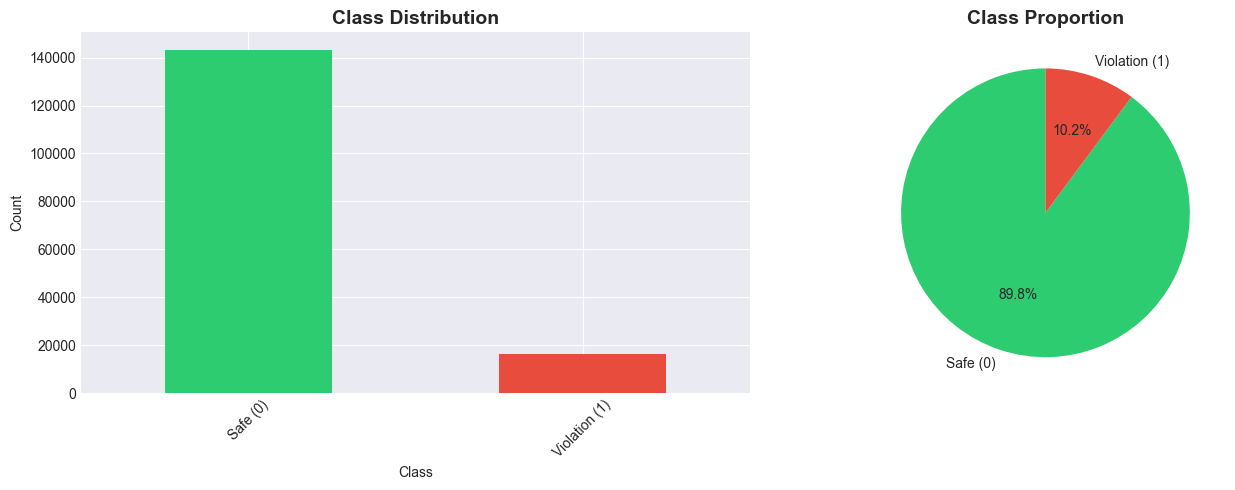

In [80]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))


class_counts = df['class'].value_counts().sort_index()
label_map = {0: 'Safe (0)', 1: 'Violation (1)'}
color_map = {0: '#2ecc71', 1: '#e74c3c'}


# Count plot
bar_colors = [color_map.get(idx, '#95a5a6') for idx in class_counts.index]
class_counts.plot(kind='bar', ax=axes[0], color=bar_colors)
axes[0].set_title('Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels([label_map.get(idx, f'Class {idx}') for idx in class_counts.index], rotation=45)


# Pie chart
pie_colors = [color_map.get(idx, '#95a5a6') for idx in class_counts.index]
axes[1].pie(
    class_counts,
    labels=[label_map.get(idx, f'Class {idx}') for idx in class_counts.index],
    autopct='%1.1f%%',
    colors=pie_colors,
    startangle=90
)
axes[1].set_title('Class Proportion', fontsize=14, fontweight='bold')


plt.tight_layout()
plt.show()

## 4. Data Preprocessing

In [81]:
# Remove missing values
df = df.dropna(subset=['tweet', 'class'])
print(f"Dataset shape after removing NaN: {df.shape}")

Dataset shape after removing NaN: (159571, 9)


In [82]:
# Text cleaning function
def normalize_repeated_chars(text: str, max_repeats: int = 2) -> str:
    """Collapse long character runs like 'soooo' → 'soo' for stabler models."""
    pattern = re.compile(rf"([a-zA-Z])\1{{{max_repeats},}}")
    return pattern.sub(lambda m: m.group(1) * max_repeats, text)

def clean_text(text):
    """
    Clean and preprocess text data
    """
    # Convert to string and lowercase
    text = str(text).lower()
    
    # Normalize character repetitions before further cleaning
    text = normalize_repeated_chars(text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove user mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # Remove HTML entities
    text = re.sub(r'&\w+;|&#\d+;', '', text)
    
    # Remove special characters and numbers (keep only letters and spaces)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply cleaning
df['cleaned_tweet'] = df['tweet'].apply(clean_text)

print("Cleaning Examples:")
for i in range(3):
    print(f"\nOriginal: {df['tweet'].iloc[i][:80]}...")
    print(f"Cleaned:  {df['cleaned_tweet'].iloc[i][:80]}...")

Cleaning Examples:

Original: Explanation
Why the edits made under my username Hardcore Metallica Fan were re...
Cleaned:  explanation why the edits made under my username hardcore metallica fan were rev...

Original: D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (tal...
Cleaned:  d aww he matches this background colour i m seemingly stuck with thanks talk jan...

Original: Hey man, I'm really not trying to edit war. It's just that this guy is constantl...
Cleaned:  hey man i m really not trying to edit war it s just that this guy is constantly ...


In [83]:
# Advanced preprocessing with lemmatization
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Advanced preprocessing: tokenization, stopword removal, lemmatization
    """
    try:
        # Tokenize
        tokens = word_tokenize(text)
        
        # Remove stopwords and lemmatize
        tokens = [lemmatizer.lemmatize(word) for word in tokens 
                  if word not in stop_words and len(word) > 2]
        
        return ' '.join(tokens)
    except:
        return text

print("Applying advanced preprocessing...")
df['processed_tweet'] = df['cleaned_tweet'].apply(preprocess_text)
print("✓ Preprocessing completed")

# Show examples
print("\nPreprocessing Examples:")
for i in range(3):
    print(f"\nCleaned:    {df['cleaned_tweet'].iloc[i][:60]}...")
    print(f"Processed:  {df['processed_tweet'].iloc[i][:60]}...")

Applying advanced preprocessing...
✓ Preprocessing completed

Preprocessing Examples:

Cleaned:    explanation why the edits made under my username hardcore me...
Processed:  explanation edits made username hardcore metallica fan rever...

Cleaned:    d aww he matches this background colour i m seemingly stuck ...
Processed:  aww match background colour seemingly stuck thanks talk janu...

Cleaned:    hey man i m really not trying to edit war it s just that thi...
Processed:  hey man really trying edit war guy constantly removing relev...


### 4.1. Train Byte-level BPE Tokenizer

In [84]:
# Initialize and train Byte-level BPE Tokenizer
print("Training Byte-level BPE Tokenizer...")

# Initialize tokenizer
bpe_tokenizer = ByteLevelBPETokenizer()

# Create temporary file with cleaned tweets for training
temp_corpus_file = project_root / 'temp_corpus.txt'
with open(temp_corpus_file, 'w', encoding='utf-8') as f:
    for text in df['cleaned_tweet'].dropna():
        f.write(text + '\n')

# Train BPE tokenizer
# vocab_size: number of merge operations (typical: 5000-50000)
# min_frequency: minimum frequency for a token to be included
bpe_tokenizer.train(
    files=[str(temp_corpus_file)],
    vocab_size=10000,  # vocabulary size
    min_frequency=5,   # minimum frequency
    special_tokens=["<pad>", "<unk>", "<s>", "</s>"]
)

# Save trained tokenizer
tokenizer_dir = project_root / 'saved_models'
tokenizer_dir.mkdir(exist_ok=True)
bpe_tokenizer.save_model(str(tokenizer_dir), "bpe_tokenizer")

print(f"✓ BPE Tokenizer trained and saved to {tokenizer_dir}")
print(f"  Vocabulary size: {bpe_tokenizer.get_vocab_size()}")

# Clean up temp file
temp_corpus_file.unlink()

# Test tokenizer
test_sentences = [
    "I love this beautiful day!",
    "You are stupid and worthless",
    "CONGRATULATIONS! You won a free iPhone!"
]

print("\nBPE Tokenization Examples:")
print("="*80)
for sent in test_sentences:
    encoded = bpe_tokenizer.encode(sent)
    tokens = encoded.tokens
    ids = encoded.ids
    print(f"\nOriginal: {sent}")
    print(f"Tokens:   {tokens[:20]}...")  # Show first 20 tokens
    print(f"Token IDs: {ids[:20]}...")
    print(f"Total tokens: {len(tokens)}")

Training Byte-level BPE Tokenizer...
✓ BPE Tokenizer trained and saved to D:\SE405_SE400\SE400_Seminar_CNPM\saved_models
  Vocabulary size: 10000

BPE Tokenization Examples:

Original: I love this beautiful day!
Tokens:   ['I', 'Ġlove', 'Ġthis', 'Ġbeautiful', 'Ġday', '!']...
Token IDs: [44, 1605, 338, 6287, 937, 4]...
Total tokens: 6

Original: You are stupid and worthless
Tokens:   ['Y', 'ou', 'Ġare', 'Ġstupid', 'Ġand', 'Ġworthless']...
Token IDs: [60, 270, 357, 1831, 302, 6428]...
Total tokens: 6

Original: CONGRATULATIONS! You won a free iPhone!
Tokens:   ['C', 'O', 'N', 'G', 'R', 'A', 'T', 'U', 'L', 'A', 'T', 'I', 'O', 'N', 'S', '!', 'Ġ', 'Y', 'ou', 'Ġwon']...
Token IDs: [38, 50, 49, 42, 53, 36, 55, 56, 47, 36, 55, 44, 50, 49, 54, 4, 224, 60, 270, 1113]...
Total tokens: 27
✓ BPE Tokenizer trained and saved to D:\SE405_SE400\SE400_Seminar_CNPM\saved_models
  Vocabulary size: 10000

BPE Tokenization Examples:

Original: I love this beautiful day!
Tokens:   ['I', 'Ġlove', 'Ġthis', 'Ġb

In [85]:
# Apply BPE tokenization to dataset
def tokenize_with_bpe(text):
    """Apply BPE tokenization and return space-separated tokens"""
    try:
        encoded = bpe_tokenizer.encode(text)
        return ' '.join(encoded.tokens)
    except:
        return text

print("Applying BPE tokenization to dataset...")
df['bpe_tokenized'] = df['cleaned_tweet'].apply(tokenize_with_bpe)
print("✓ BPE tokenization completed")

# Show comparison: NLTK vs BPE tokenization
print("\nComparison: NLTK word_tokenize vs BPE tokenization")
print("="*80)
for i in range(3):
    print(f"\nOriginal:  {df['tweet'].iloc[i][:70]}...")
    print(f"Cleaned:   {df['cleaned_tweet'].iloc[i][:70]}...")
    print(f"NLTK:      {df['processed_tweet'].iloc[i][:70]}...")
    print(f"BPE:       {df['bpe_tokenized'].iloc[i][:70]}...")

Applying BPE tokenization to dataset...
✓ BPE tokenization completed

Comparison: NLTK word_tokenize vs BPE tokenization

Original:  Explanation
Why the edits made under my username Hardcore Metallica F...
Cleaned:   explanation why the edits made under my username hardcore metallica fa...
NLTK:      explanation edits made username hardcore metallica fan reverted vandal...
BPE:       ex pl an ation Ġwhy Ġthe Ġedits Ġmade Ġunder Ġmy Ġusername Ġhardcore Ġ...

Original:  D'aww! He matches this background colour I'm seemingly stuck with. Tha...
Cleaned:   d aww he matches this background colour i m seemingly stuck with thank...
NLTK:      aww match background colour seemingly stuck thanks talk january utc...
BPE:       d Ġaw w Ġhe Ġmatches Ġthis Ġbackground Ġcolour Ġi Ġm Ġseemingly Ġstuck...

Original:  Hey man, I'm really not trying to edit war. It's just that this guy is...
Cleaned:   hey man i m really not trying to edit war it s just that this guy is c...
NLTK:      hey man really tryi

### 4.2. Compare Tokenization Methods

In [86]:
# Compare statistics between NLTK and BPE tokenization
print("Tokenization Statistics Comparison:")
print("="*80)

# Calculate average tokens per sentence
nltk_tokens_avg = df['processed_tweet'].str.split().str.len().mean()
bpe_tokens_avg = df['bpe_tokenized'].str.split().str.len().mean()

# Calculate vocabulary sizes
nltk_vocab = set(' '.join(df['processed_tweet'].dropna()).split())
bpe_vocab_size = bpe_tokenizer.get_vocab_size()

print(f"\nNLTK Word Tokenization:")
print(f"  Average tokens per text: {nltk_tokens_avg:.2f}")
print(f"  Unique vocabulary size: {len(nltk_vocab):,}")

print(f"\nByte-level BPE Tokenization:")
print(f"  Average tokens per text: {bpe_tokens_avg:.2f}")
print(f"  Vocabulary size: {bpe_vocab_size:,}")

print(f"\nAdvantages of BPE:")
print("  ✓ Handles out-of-vocabulary (OOV) words better")
print("  ✓ Fixed vocabulary size (memory efficient)")
print("  ✓ Subword tokenization (captures morphology)")
print("  ✓ Better for rare/misspelled words")
print("  ✓ Language-agnostic (works with any text)")

# Show specific examples where BPE performs better
print("\n" + "="*80)
print("Examples where BPE handles better:")
print("="*80)

test_cases = [
    "fuckkkking idiotttt",  # repeated chars
    "loooooove",  # elongated word
    "COVID-19",  # special tokens
    "whaaaaat???!!!",  # mixed
]

for text in test_cases:
    cleaned = clean_text(text)
    nltk_result = preprocess_text(cleaned)
    bpe_result = tokenize_with_bpe(cleaned)
    
    print(f"\nOriginal: {text}")
    print(f"NLTK:     {nltk_result}")
    print(f"BPE:      {bpe_result}")

Tokenization Statistics Comparison:

NLTK Word Tokenization:
  Average tokens per text: 33.31
  Unique vocabulary size: 151,810

Byte-level BPE Tokenization:
  Average tokens per text: 76.63
  Vocabulary size: 10,000

Advantages of BPE:
  ✓ Handles out-of-vocabulary (OOV) words better
  ✓ Fixed vocabulary size (memory efficient)
  ✓ Subword tokenization (captures morphology)
  ✓ Better for rare/misspelled words
  ✓ Language-agnostic (works with any text)

Examples where BPE handles better:

Original: fuckkkking idiotttt
NLTK:     fuckking idiott
BPE:      fuck king Ġidiot t

Original: loooooove
NLTK:     loove
BPE:      l oo ve

Original: COVID-19
NLTK:     covid
BPE:      co v id

Original: whaaaaat???!!!
NLTK:     whaat
BPE:      wh a at

NLTK Word Tokenization:
  Average tokens per text: 33.31
  Unique vocabulary size: 151,810

Byte-level BPE Tokenization:
  Average tokens per text: 76.63
  Vocabulary size: 10,000

Advantages of BPE:
  ✓ Handles out-of-vocabulary (OOV) words better


### 📊 Summary: Byte-level BPE vs NLTK Tokenization

**Byte-level BPE (Byte Pair Encoding)** là phương pháp tokenization hiện đại được sử dụng trong các model như GPT-2, RoBERTa, BERT.

#### 🔑 Key Differences:

| Feature | NLTK word_tokenize | Byte-level BPE |
|---------|-------------------|----------------|
| **Approach** | Splits by whitespace & punctuation | Learns subword units from corpus |
| **OOV Handling** | Unknown words become `<UNK>` | Breaks into known subwords |
| **Vocabulary** | Unlimited (grows with corpus) | Fixed size (e.g., 10,000) |
| **Memory** | Can be very large | Memory efficient |
| **Misspellings** | Treats as separate words | Captures partial meaning |
| **Morphology** | No subword info | Captures prefixes/suffixes |

#### ✅ When to use BPE:
- Noisy text with typos/slang (social media, comments)
- Multilingual data
- Limited vocabulary size requirements
- Modern transformer models (BERT, GPT, RoBERTa)

#### ⚠️ When to use NLTK:
- Simple bag-of-words models
- Small, clean datasets
- Need interpretable tokens
- Traditional ML models (Naive Bayes, SVM)

#### 📁 Files saved:
- `saved_models/bpe_tokenizer-vocab.json` - BPE vocabulary
- `saved_models/bpe_tokenizer-merges.txt` - Merge operations

#### 🔄 Usage:
```python
# Tokenize new text
text = "Hello world!"
encoded = bpe_tokenizer.encode(text)
tokens = encoded.tokens  # ['Hello', 'Ġworld', '!']
ids = encoded.ids        # [123, 456, 4]
```

---

### 💡 Note: Model Integration

**Current pipeline** vẫn sử dụng NLTK tokenization cho ML model vì:
1. Naive Bayes + TF-IDF đã được train với NLTK tokens
2. BPE tokenizer cần re-train toàn bộ model với BPE features

**Để sử dụng BPE trong production:**
1. Re-train model với `X = df['bpe_tokenized']` thay vì `X = df['processed_tweet']`
2. Update `HybridToxicClassifier.predict()` để dùng BPE tokenizer
3. Save BPE tokenizer cùng với model artifacts

**Hoặc** giữ cả 2 phương pháp:
- NLTK cho model hiện tại (backward compatibility)
- BPE cho model mới (better performance với noisy text)

## 5. Feature Engineering

In [87]:
# Prepare data for modeling
X = df['processed_tweet']
y = df['class']


# Convert to binary classification (any toxic flag -> Violation)
# Kaggle train.csv already uses 0/1 targets, but keep explicit transform for clarity
y_binary = (y != 0).astype(int)


print("Data ready for modeling:")
print(f"Total samples: {len(X)}")
print(f"Binary classes: {sorted(y_binary.unique())}")
print(y_binary.value_counts())
print(f"\nViolation rate: {y_binary.mean():.2%}")

Data ready for modeling:
Total samples: 159571
Binary classes: [np.int64(0), np.int64(1)]
class
0    143346
1     16225
Name: count, dtype: int64

Violation rate: 10.17%


In [88]:
# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTest set class distribution:")
print(y_test.value_counts())

Training set size: 127656
Test set size: 31915

Training set class distribution:
class
0    114676
1     12980
Name: count, dtype: int64

Test set class distribution:
class
0    28670
1     3245
Name: count, dtype: int64


In [89]:
# TF-IDF Vectorization (optimized for Naive Bayes)
tfidf_vectorizer = TfidfVectorizer(
    max_features=3000,
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.9,
    sublinear_tf=True  # Better for Naive Bayes
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF feature shape: {X_train_tfidf.shape}")
print(f"Number of features: {len(tfidf_vectorizer.get_feature_names_out())}")

TF-IDF feature shape: (127656, 3000)
Number of features: 3000


## 5.1. Balance Dataset with SMOTE

In [90]:
# Apply SMOTE to balance training data
print("Applying SMOTE to balance training data...")
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_tfidf, y_train)

print(f"Before SMOTE: {y_train.value_counts().to_dict()}")
print(f"After SMOTE:  {pd.Series(y_train_balanced).value_counts().to_dict()}")
print(f"Balanced training set size: {len(y_train_balanced)}")

Applying SMOTE to balance training data...
Before SMOTE: {0: 114676, 1: 12980}
After SMOTE:  {0: 114676, 1: 114676}
Balanced training set size: 229352
Before SMOTE: {0: 114676, 1: 12980}
After SMOTE:  {0: 114676, 1: 114676}
Balanced training set size: 229352


## 6. Train Naive Bayes Models

In [91]:
# Compare different Naive Bayes variants WITH BALANCED DATA
nb_models = {
    'MultinomialNB': MultinomialNB(),
    'ComplementNB': ComplementNB(),
    'BernoulliNB': BernoulliNB()
}

results = {}

print("Training Naive Bayes variants with BALANCED data...\n")
print("="*80)

for name, model in nb_models.items():
    print(f"\n{name}:")
    print("-" * 60)
    
    # Train with BALANCED data
    model.fit(X_train_balanced, y_train_balanced)
    
    # Predict on original test set
    y_pred = model.predict(X_test_tfidf)
    y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1]
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Cross-validation on balanced data
    cv_scores = cross_val_score(model, X_train_balanced, y_train_balanced, cv=5, scoring='f1')
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'cv_f1_mean': cv_scores.mean(),
        'cv_f1_std': cv_scores.std(),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"CV F1:     {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

print("\n" + "="*80)
print("✓ All Naive Bayes models trained with BALANCED data")

Training Naive Bayes variants with BALANCED data...


MultinomialNB:
------------------------------------------------------------
Accuracy:  0.8957
Precision: 0.4923
Recall:    0.8367
F1-Score:  0.6199
CV F1:     0.8721 (+/- 0.0016)

ComplementNB:
------------------------------------------------------------
Accuracy:  0.8957
Precision: 0.4923
Recall:    0.8367
F1-Score:  0.6199
CV F1:     0.8721 (+/- 0.0016)

ComplementNB:
------------------------------------------------------------
Accuracy:  0.8957
Precision: 0.4923
Recall:    0.8367
F1-Score:  0.6199
CV F1:     0.8713 (+/- 0.0024)

BernoulliNB:
------------------------------------------------------------
Accuracy:  0.8957
Precision: 0.4923
Recall:    0.8367
F1-Score:  0.6199
CV F1:     0.8713 (+/- 0.0024)

BernoulliNB:
------------------------------------------------------------
Accuracy:  0.5819
Precision: 0.1838
Recall:    0.9045
F1-Score:  0.3055
CV F1:     0.7708 (+/- 0.0014)

✓ All Naive Bayes models trained with BALANCED data



Naive Bayes Model Comparison:
        Model  Accuracy  Precision   Recall  F1-Score    CV F1
MultinomialNB  0.895660   0.492294 0.836672  0.619863 0.872078
 ComplementNB  0.895660   0.492294 0.836672  0.619863 0.871274
  BernoulliNB  0.581921   0.183805 0.904468  0.305522 0.770797


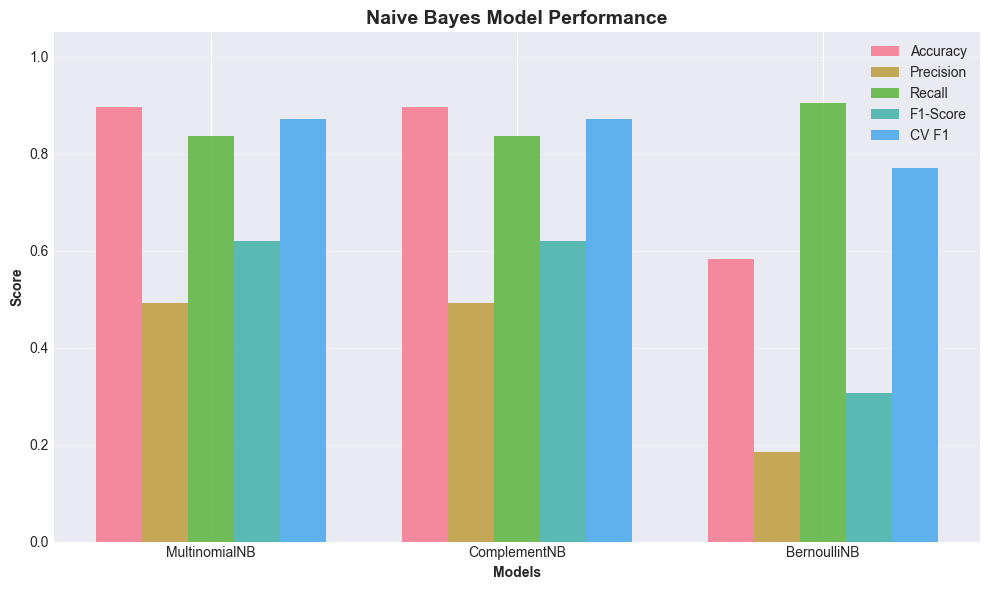

In [92]:
# Compare models
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results],
    'Precision': [results[m]['precision'] for m in results],
    'Recall': [results[m]['recall'] for m in results],
    'F1-Score': [results[m]['f1'] for m in results],
    'CV F1': [results[m]['cv_f1_mean'] for m in results]
})

comparison_df = comparison_df.sort_values('F1-Score', ascending=False)
print("\nNaive Bayes Model Comparison:")
print(comparison_df.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(comparison_df))
width = 0.15

ax.bar(x - 2*width, comparison_df['Accuracy'], width, label='Accuracy', alpha=0.8)
ax.bar(x - width, comparison_df['Precision'], width, label='Precision', alpha=0.8)
ax.bar(x, comparison_df['Recall'], width, label='Recall', alpha=0.8)
ax.bar(x + width, comparison_df['F1-Score'], width, label='F1-Score', alpha=0.8)
ax.bar(x + 2*width, comparison_df['CV F1'], width, label='CV F1', alpha=0.8)

ax.set_xlabel('Models', fontweight='bold')
ax.set_ylabel('Score', fontweight='bold')
ax.set_title('Naive Bayes Model Performance', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'])
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.05])

plt.tight_layout()
plt.show()

In [93]:
# Select best model
best_model_name = comparison_df.iloc[0]['Model']
best_model_results = results[best_model_name]

print(f"\n🏆 Best Naive Bayes Model: {best_model_name}")
print(f"   F1-Score: {best_model_results['f1']:.4f}")
print(f"   Accuracy: {best_model_results['accuracy']:.4f}")
print(f"   Precision: {best_model_results['precision']:.4f}")
print(f"   Recall: {best_model_results['recall']:.4f}")


🏆 Best Naive Bayes Model: MultinomialNB
   F1-Score: 0.6199
   Accuracy: 0.8957
   Precision: 0.4923
   Recall: 0.8367


## 7. Hyperparameter Tuning

In [94]:
# Define parameter grid for best model
if best_model_name == 'MultinomialNB':
    param_grid = {
        'alpha': [0.01, 0.1, 0.5, 1.0, 2.0],
        'fit_prior': [True, False]
    }
    tuning_model = MultinomialNB()
elif best_model_name == 'ComplementNB':
    param_grid = {
        'alpha': [0.01, 0.1, 0.5, 1.0, 2.0],
        'norm': [True, False]
    }
    tuning_model = ComplementNB()
else:  # BernoulliNB
    param_grid = {
        'alpha': [0.01, 0.1, 0.5, 1.0, 2.0],
        'binarize': [0.0, 0.5, 1.0],
        'fit_prior': [True, False]
    }
    tuning_model = BernoulliNB()

print(f"Tuning {best_model_name}...")
print(f"Parameter grid: {param_grid}")

Tuning MultinomialNB...
Parameter grid: {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0], 'fit_prior': [True, False]}


In [95]:
# Grid Search with BALANCED data
grid_search = GridSearchCV(
    tuning_model,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Use BALANCED data for training
grid_search.fit(X_train_balanced, y_train_balanced)

print(f"\n✓ Grid Search completed (with balanced data)")
print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best CV F1-Score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits

✓ Grid Search completed (with balanced data)

Best Parameters: {'alpha': 2.0, 'fit_prior': True}
Best CV F1-Score: 0.8727

✓ Grid Search completed (with balanced data)

Best Parameters: {'alpha': 2.0, 'fit_prior': True}
Best CV F1-Score: 0.8727


In [96]:
# Evaluate tuned model
tuned_model = grid_search.best_estimator_
y_pred_tuned = tuned_model.predict(X_test_tfidf)
y_pred_proba_tuned = tuned_model.predict_proba(X_test_tfidf)[:, 1]

print("\nTuned Model Performance:")
print("="*60)
print(f"Accuracy:  {accuracy_score(y_test, y_pred_tuned):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_tuned):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_tuned):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_tuned):.4f}")

print("\n" + "="*60)
print("Improvement (Before → After Tuning):")
print(f"F1-Score:  {best_model_results['f1']:.4f} → {f1_score(y_test, y_pred_tuned):.4f}")
print(f"Accuracy:  {best_model_results['accuracy']:.4f} → {accuracy_score(y_test, y_pred_tuned):.4f}")


Tuned Model Performance:
Accuracy:  0.8958
Precision: 0.4928
Recall:    0.8388
F1-Score:  0.6209

Improvement (Before → After Tuning):
F1-Score:  0.6199 → 0.6209
Accuracy:  0.8957 → 0.8958


## 8. Model Evaluation

In [97]:
# Classification Report
print(f"Classification Report - {best_model_name} (Tuned):")
print("="*60)
print(classification_report(y_test, y_pred_tuned, target_names=['Safe (0)', 'Violation (1)']))

Classification Report - MultinomialNB (Tuned):
               precision    recall  f1-score   support

     Safe (0)       0.98      0.90      0.94     28670
Violation (1)       0.49      0.84      0.62      3245

     accuracy                           0.90     31915
    macro avg       0.74      0.87      0.78     31915
 weighted avg       0.93      0.90      0.91     31915



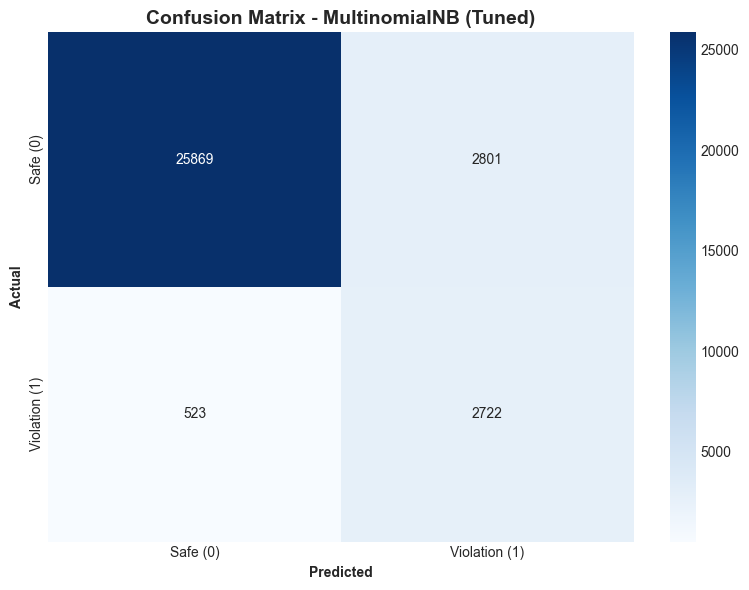


Confusion Matrix Breakdown:
True Negatives (TN):  25869
False Positives (FP): 2801
False Negatives (FN): 523
True Positives (TP):  2722

False Positive Rate: 0.0977
False Negative Rate: 0.1612


In [98]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tuned)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Safe (0)', 'Violation (1)'],
            yticklabels=['Safe (0)', 'Violation (1)'])
plt.title(f'Confusion Matrix - {best_model_name} (Tuned)', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.tight_layout()
plt.show()

# Metrics from confusion matrix
tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix Breakdown:")
print(f"True Negatives (TN):  {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP):  {tp}")
print(f"\nFalse Positive Rate: {fp/(fp+tn):.4f}")
print(f"False Negative Rate: {fn/(fn+tp):.4f}")

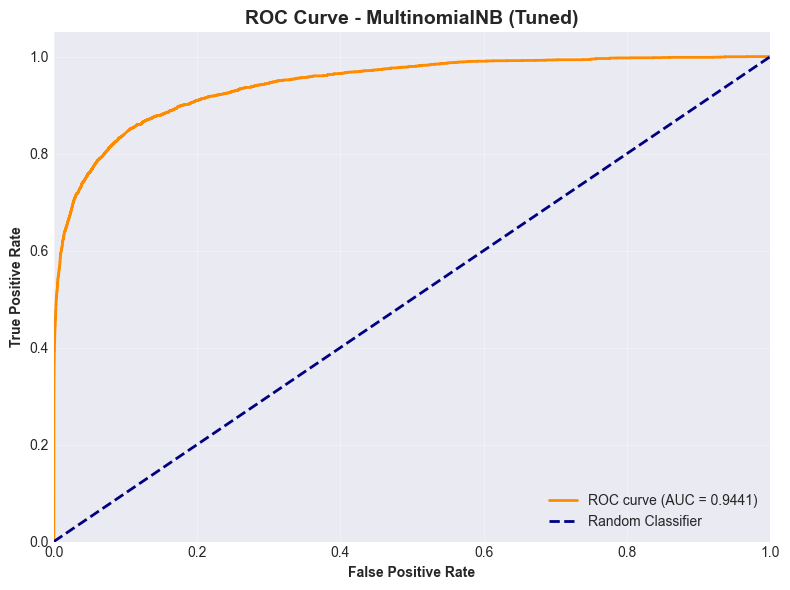

AUC-ROC Score: 0.9441


In [99]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_tuned)
roc_auc = roc_auc_score(y_test, y_pred_proba_tuned)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.title(f'ROC Curve - {best_model_name} (Tuned)', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"AUC-ROC Score: {roc_auc:.4f}")

## 9. Build Hybrid Prediction System

In [100]:
# Hybrid Prediction Class
class HybridToxicClassifier:
    """Hybrid classifier combining Rule-based Filter + ML Model with tiered policy labels."""
    DEFAULT_SPAM_KEYWORDS = (
        # Common spam triggers
        'buy now', 'order now', 'click here', 'limited offer', 'flash sale', 'discount',
        'promo code', 'coupon', 'free shipping', 'subscribe now', 'follow my channel',
        'visit our website', 'visit my channel', 'hotline', 'liên hệ', 'mua ngay',
        'giảm giá', 'khuyến mãi', 'ưu đãi', 'zalo', 'telegram', 'inbox', 'dm for price',
        'săn sale', 'deal độc quyền',
        # Scam/prize/urgency keywords
        'congratulations', 'you won', 'you have won', 'free iphone', 'free phone', 'claim now',
        'claim here', 'click to claim', 'winner', 'selected winner', 'lucky winner',
        'make $', 'earn $', 'make money', 'from home', 'zero effort', 'no effort',
        'miracle pill', 'lose weight', 'lose 20lbs', 'guaranteed', '100% guaranteed',
        'urgent', 'account compromised', 'verify now', 'verify identity', 'verify account',
        'suspended account', 'unusual activity', 'confirm identity', 'security alert',
        'act now', 'limited time', 'expires soon', 'last chance', 'dont miss',
        'risk free', 'no risk', 'money back', 'refund guarantee'
    )
    URL_PATTERN = re.compile(r'(https?://|www\.|\.com\b|\.vn\b|\.net\b|\[link\])', re.IGNORECASE)
    PHONE_PATTERN = re.compile(r'(?:\+?\d[\s-]?){7,}')
    REPEATED_EXCLAMATION_PATTERN = re.compile(r'!{2,}')
    MONEY_PATTERN = re.compile(r'\$\d+|\d+\s*(?:đô|dollar|usd|vnd|đồng)', re.IGNORECASE)
    CAPS_WORDS_PATTERN = re.compile(r'\b[A-Z]{4,}\b')

    def __init__(self, ml_model, vectorizer, rule_detector=None, *,
                 warning_threshold: float = 0.6, violation_threshold: float | None = 0.8,
                 spam_keywords=None):
        """
        Args:
            warning_threshold: lower bound for WARNING tier (SAFE < warning_threshold).
            violation_threshold: strict lower bound for VIOLATION tier (probability must be > value).
        """
        if violation_threshold is None:
            violation_threshold = 0.8
        if warning_threshold >= violation_threshold:
            raise ValueError("warning_threshold must be lower than violation_threshold")

        self.ml_model = ml_model
        self.vectorizer = vectorizer
        self.rule_detector = rule_detector
        self.warning_threshold = warning_threshold
        self.violation_threshold = violation_threshold
        self.ml_threshold = violation_threshold  # backward compatibility for legacy callers
        self.spam_keywords = tuple(spam_keywords) if spam_keywords else self.DEFAULT_SPAM_KEYWORDS

    def _detect_spam(self, raw_text: str):
        """Enhanced heuristic-based spam/scam detector forcing VIOLATION."""
        text_lower = raw_text.lower()

        # Check for spam keywords
        for keyword in self.spam_keywords:
            if keyword in text_lower:
                return f"keyword:{keyword}"

        # Check for URLs/links
        if self.URL_PATTERN.search(raw_text):
            return 'contains_link'

        # Check for phone numbers
        if self.PHONE_PATTERN.search(raw_text):
            return 'contact_number'

        # Check for excessive punctuation (2+ exclamation marks)
        if self.REPEATED_EXCLAMATION_PATTERN.search(raw_text):
            return 'excessive_punctuation'

        # Check for money mentions (common in scams)
        if self.MONEY_PATTERN.search(raw_text):
            return 'money_mention'

        # Check for excessive capital letters (common in spam)
        caps_words = self.CAPS_WORDS_PATTERN.findall(raw_text)
        if len(caps_words) >= 2:  # 2 or more ALL CAPS words
            return 'excessive_caps'

        return None

    def _label_from_probability(self, probability: float):
        if probability > self.violation_threshold:
            return 'VIOLATION', True
        if probability >= self.warning_threshold:
            return 'WARNING', False
        return 'SAFE', False

    def predict(self, text, return_details=False):
        """Predict using hybrid approach with SAFE/WARNING/VIOLATION outputs."""
        # Step 1: Rule-based filter
        rule_phrases = []
        spam_indicator = self._detect_spam(text)
        if spam_indicator:
            return {
                'text': text,
                'is_violation': True,
                'label': 'VIOLATION',
                'method': 'spam_filter',
                'ml_probability': None,
                'confidence': 0.92,
                'toxic_phrases': [],
                'spam_indicator': spam_indicator,
                'details': 'Detected promotional / spam content'
            }
        if self.rule_detector is not None:
            try:
                rule_result = self.rule_detector.detect(text, return_details=True)
                if rule_result.get('is_toxic', False):
                    return {
                        'text': text,
                        'is_violation': True,
                        'label': 'VIOLATION',
                        'method': 'rule_based',
                        'ml_probability': None,
                        'confidence': 0.95,
                        'toxic_phrases': rule_result.get('toxic_phrases', []),
                        'spam_indicator': None,
                        'details': 'Detected by rule-based filter'
                    }
                rule_phrases = rule_result.get('toxic_phrases', [])
            except Exception as e:
                print(f"Rule detector error: {e}")

        # Step 2: ML Model prediction
        cleaned = clean_text(text)
        processed = preprocess_text(cleaned)
        vectorized = self.vectorizer.transform([processed])
        ml_probability = float(self.ml_model.predict_proba(vectorized)[0][1])

        label, is_violation = self._label_from_probability(ml_probability)
        confidence = ml_probability if label != 'SAFE' else (1 - ml_probability)
        details = (
            f"Prob={ml_probability:.4f} | tiers -> "
            f"SAFE < {self.warning_threshold:.2f}, "
            f"WARNING [{self.warning_threshold:.2f}, {self.violation_threshold:.2f}], "
            f"VIOLATION > {self.violation_threshold:.2f}"
        )
        return {
            'text': text,
            'is_violation': is_violation,
            'label': label,
            'method': 'ml_model',
            'ml_probability': ml_probability,
            'confidence': float(confidence),
            'toxic_phrases': rule_phrases,
            'spam_indicator': None,
            'details': details,
            'risk_level': label
        }

print("✓ HybridToxicClassifier defined with SAFE/WARNING/VIOLATION tiers")

✓ HybridToxicClassifier defined with SAFE/WARNING/VIOLATION tiers


In [101]:
# Initialize Hybrid Classifier with SAFE/WARNING/VIOLATION tiers
hybrid_classifier = HybridToxicClassifier(
    ml_model=tuned_model,
    vectorizer=tfidf_vectorizer,
    rule_detector=rule_based_detector,
    warning_threshold=0.6,
    violation_threshold=0.8
)

print("✓ Hybrid Classifier initialized")
print(f"  ML Model: {best_model_name} (Tuned)")
print(f"  Rule-based: {'Enabled' if rule_based_detector else 'Disabled'}")
print(
    "  Probability tiers -> SAFE < {safe:.2f} | WARNING [{safe:.2f}, {viol:.2f}) | VIOLATION ≥ {viol:.2f}"
    .format(safe=hybrid_classifier.warning_threshold, viol=hybrid_classifier.violation_threshold)
 )
print("  Training: Balanced with SMOTE")

✓ Hybrid Classifier initialized
  ML Model: MultinomialNB (Tuned)
  Rule-based: Enabled
  Probability tiers -> SAFE < 0.60 | WARNING [0.60, 0.80) | VIOLATION ≥ 0.80
  Training: Balanced with SMOTE


## 10. Test Hybrid System

In [102]:
# Test cases
test_texts = [
    "I love this beautiful day!",
    "This movie was amazing",
    "You are stupid and worthless",
    "I hate you so much you idiot",
    "Stop posting ragebait content",
    "This is pure brainrot",
    "Thank you for your help!",
    "What a wonderful experience"
]

print("Testing Hybrid Classifier:")
print("="*80)

for text in test_texts:
    result = hybrid_classifier.predict(text)
    print(f"\nText: {text}")
    print(f"Label: {result['label']}")
    print(f"Method: {result['method']}")
    if result['ml_probability'] is not None:
        print(f"ML Probability: {result['ml_probability']:.4f}")
    print(f"Confidence: {result['confidence']:.4f}")
    if result['toxic_phrases']:
        print(f"Toxic Phrases: {', '.join(result['toxic_phrases'])}")

Testing Hybrid Classifier:

Text: I love this beautiful day!
Label: WARNING
Method: ml_model
ML Probability: 0.7065
Confidence: 0.7065

Text: This movie was amazing
Label: SAFE
Method: ml_model
ML Probability: 0.4442
Confidence: 0.5558

Text: You are stupid and worthless
Label: VIOLATION
Method: ml_model
ML Probability: 0.9766
Confidence: 0.9766

Text: I hate you so much you idiot
Label: VIOLATION
Method: ml_model
ML Probability: 0.9884
Confidence: 0.9884

Text: Stop posting ragebait content
Label: VIOLATION
Method: rule_based
Confidence: 0.9500
Toxic Phrases: ragebait

Text: This is pure brainrot
Label: VIOLATION
Method: rule_based
Confidence: 0.9500
Toxic Phrases: brainrot

Text: Thank you for your help!
Label: SAFE
Method: ml_model
ML Probability: 0.1390
Confidence: 0.8610

Text: What a wonderful experience
Label: SAFE
Method: ml_model
ML Probability: 0.2952
Confidence: 0.7048

Text: What a wonderful experience
Label: SAFE
Method: ml_model
ML Probability: 0.2952
Confidence: 0.7048


### 10.1. Test Different Thresholds

### 10.0. Diagnostic - Check Rule-Based Detector

In [103]:
# Diagnostic: Test rule-based detector directly
print("Testing Rule-Based Detector:")
print("="*80)

if rule_based_detector is not None:
    toxic_test_phrases = [
        "fucking bitch",
        "you stupid idiot",
        "I hate niggers", 
        "kill yourself",
        "You are stupid and worthless",
        "I hate you so much you idiot"
    ]
    
    for text in toxic_test_phrases:
        try:
            result = rule_based_detector.detect(text, return_details=True)
            print(f"\nText: '{text}'")
            print(f"  Is Toxic: {result.get('is_toxic', False)}")
            print(f"  Phrases: {result.get('toxic_phrases', [])}")
        except Exception as e:
            print(f"\nText: '{text}'")
            print(f"  Error: {e}")
else:
    print("Rule-based detector not available!")

print("\n" + "="*80)
print("\nTesting ML Model directly:")
print("="*80)

# Test ML model prediction directly (bypass rule-based)
test_cases = [
    "I love this beautiful day!",
    "fucking bitch you idiot",
    "Thank you very much",
    "kill yourself stupid"
]

for text in test_cases:
    cleaned = clean_text(text)
    processed = preprocess_text(cleaned)
    vectorized = tfidf_vectorizer.transform([processed])
    
    ml_pred = tuned_model.predict(vectorized)[0]
    ml_proba = tuned_model.predict_proba(vectorized)[0]
    
    print(f"\nText: '{text}'")
    print(f"  Cleaned: '{cleaned}'")
    print(f"  Processed: '{processed}'")
    print(f"  ML Prediction: {ml_pred} (0=Safe, 1=Violation)")
    print(f"  ML Probability: [Safe: {ml_proba[0]:.4f}, Violation: {ml_proba[1]:.4f}]")

Testing Rule-Based Detector:

Text: 'fucking bitch'
  Is Toxic: True
  Phrases: ['bitch']

Text: 'you stupid idiot'
  Is Toxic: False
  Phrases: []

Text: 'I hate niggers'
  Is Toxic: False
  Phrases: []

Text: 'kill yourself'
  Is Toxic: False
  Phrases: []

Text: 'You are stupid and worthless'
  Is Toxic: False
  Phrases: []

Text: 'I hate you so much you idiot'
  Is Toxic: False
  Phrases: []


Testing ML Model directly:

Text: 'I love this beautiful day!'
  Cleaned: 'i love this beautiful day'
  Processed: 'love beautiful day'
  ML Prediction: 1 (0=Safe, 1=Violation)
  ML Probability: [Safe: 0.2935, Violation: 0.7065]

Text: 'fucking bitch you idiot'
  Cleaned: 'fucking bitch you idiot'
  Processed: 'fucking bitch idiot'
  ML Prediction: 1 (0=Safe, 1=Violation)
  ML Probability: [Safe: 0.0000, Violation: 1.0000]

Text: 'Thank you very much'
  Cleaned: 'thank you very much'
  Processed: 'thank much'
  ML Prediction: 0 (0=Safe, 1=Violation)
  ML Probability: [Safe: 0.9042, Violation:

In [104]:
# Test with different thresholds to find optimal value
print("Testing different ML thresholds to reduce false positives:")
print("="*80)

thresholds_to_test = [0.5, 0.6, 0.65, 0.7, 0.75, 0.8]
threshold_results = []

for threshold in thresholds_to_test:
    # Keep warning tier slightly below violation tier to preserve three-level policy
    warning_threshold = max(0.3, round(threshold - 0.2, 2))
    temp_classifier = HybridToxicClassifier(
        ml_model=tuned_model,
        vectorizer=tfidf_vectorizer,
        rule_detector=rule_based_detector,
        warning_threshold=warning_threshold,
        violation_threshold=threshold
    )
    
    # Test on positive examples
    positive_texts = [
        "I love this beautiful day!",
        "This movie was amazing",
        "Thank you for your help!",
        "What a wonderful experience"
    ]
    
    fp_count = 0  # False positives
    for text in positive_texts:
        result = temp_classifier.predict(text)
        if result['is_violation']:
            fp_count += 1
    
    # Test on ACTUAL toxic examples from training data
    toxic_texts = [
        "fucking bitch",
        "you stupid idiot worthless trash",
        "I hate niggers",
        "kill yourself"
    ]
    
    tp_count = 0  # True positives
    toxic_details = []
    for text in toxic_texts:
        result = temp_classifier.predict(text)
        if result['is_violation']:
            tp_count += 1
        toxic_details.append({
            'text': text,
            'violation': result['is_violation'],
            'method': result['method'],
            'prob': result.get('ml_probability', 'N/A')
        })
    
    threshold_results.append({
        'threshold': threshold,
        'warning_threshold': warning_threshold,
        'false_positives': fp_count,
        'true_positives': tp_count,
        'fp_rate': fp_count / len(positive_texts),
        'tp_rate': tp_count / len(toxic_texts)
    })
    
    print(f"\nThreshold {threshold} (warning={warning_threshold}):")
    print(f"  False Positives (on positive texts): {fp_count}/{len(positive_texts)} ({fp_count/len(positive_texts):.1%})")
    print(f"  True Positives (on toxic texts): {tp_count}/{len(toxic_texts)} ({tp_count/len(toxic_texts):.1%})")
    
    # Show details for first threshold
    if threshold == thresholds_to_test[0]:
        print(f"\n  Toxic text details (threshold={threshold}):")
        for detail in toxic_details:
            print(f"    '{detail['text'][:30]}...' -> {detail['violation']} (method={detail['method']}, prob={detail['prob']})")

# Find best threshold (minimize FP while keeping high TP)
print("\n" + "="*80)
valid_thresholds = [r for r in threshold_results if r['tp_rate'] >= 0.75]
if valid_thresholds:
    best_choice = min(valid_thresholds, key=lambda x: x['fp_rate'])
    best_threshold = best_choice['threshold']
    best_warning_threshold = best_choice['warning_threshold']
    print(f"Recommended violation threshold: {best_threshold}")
    print(f"Recommended warning threshold: {best_warning_threshold}")
    print(f"  (Achieves TP rate >= 75% with lowest FP rate)")
else:
    print("WARNING: No threshold achieves TP rate >= 75%")
    print("This indicates a problem with model training or toxic phrase detection")
    # Fall back to threshold with best balance
    best_choice = min(threshold_results, key=lambda x: (x['fp_rate'] - x['tp_rate']))
    best_threshold = best_choice['threshold']
    best_warning_threshold = best_choice['warning_threshold']
    print(f"Using threshold with best FP/TP balance: {best_threshold}")


Testing different ML thresholds to reduce false positives:

Threshold 0.5 (warning=0.3):
  False Positives (on positive texts): 1/4 (25.0%)
  True Positives (on toxic texts): 4/4 (100.0%)

  Toxic text details (threshold=0.5):
    'fucking bitch...' -> True (method=rule_based, prob=None)
    'you stupid idiot worthless tra...' -> True (method=ml_model, prob=0.996981070623566)
    'I hate niggers...' -> True (method=ml_model, prob=0.9963611347060037)
    'kill yourself...' -> True (method=ml_model, prob=0.9526330149706987)

Threshold 0.5 (warning=0.3):
  False Positives (on positive texts): 1/4 (25.0%)
  True Positives (on toxic texts): 4/4 (100.0%)

  Toxic text details (threshold=0.5):
    'fucking bitch...' -> True (method=rule_based, prob=None)
    'you stupid idiot worthless tra...' -> True (method=ml_model, prob=0.996981070623566)
    'I hate niggers...' -> True (method=ml_model, prob=0.9963611347060037)
    'kill yourself...' -> True (method=ml_model, prob=0.9526330149706987)

Th

### 10.2. Test with SAFE/WARNING/VIOLATION thresholds

In [105]:
# Re-initialize with policy thresholds (SAFE<0.6, WARNING 0.6-0.8, VIOLATION>=0.8)
policy_warning_threshold = 0.6
policy_violation_threshold = 0.8

hybrid_classifier = HybridToxicClassifier(
    ml_model=tuned_model,
    vectorizer=tfidf_vectorizer,
    rule_detector=rule_based_detector,
    warning_threshold=policy_warning_threshold,
    violation_threshold=policy_violation_threshold
)

print(
    "✓ Hybrid Classifier updated with policy thresholds: "
    f"SAFE<{policy_warning_threshold}, WARNING[{policy_warning_threshold}, {policy_violation_threshold}), "
    f"VIOLATION>={policy_violation_threshold}"
)
print(f"  (Best binary threshold from evaluation = {best_threshold:.2f})")

# Test again with all examples
test_texts = [
    "I love this beautiful day!",
    "This movie was amazing",
    "You are stupid and worthless",
    "I hate you so much you idiot",
    "Stop posting ragebait content",
    "This is pure brainrot",
    "Thank you for your help!",
    "What a wonderful experience"
 ]

print(f"\nTesting Hybrid Classifier with policy thresholds:")
print("="*80)

for text in test_texts:
    result = hybrid_classifier.predict(text)
    print(f"\nText: {text}")
    print(f"Label: {result['label']}")
    print(f"Method: {result['method']}")
    if result['ml_probability'] is not None:
        print(f"ML Probability: {result['ml_probability']:.4f}")
    print(f"Confidence: {result['confidence']:.4f}")
    if result['toxic_phrases']:
        print(f"Toxic Phrases: {', '.join(result['toxic_phrases'])}")
    if result.get('spam_indicator'):
        print(f"Spam Indicator: {result['spam_indicator']}")

✓ Hybrid Classifier updated with policy thresholds: SAFE<0.6, WARNING[0.6, 0.8), VIOLATION>=0.8
  (Best binary threshold from evaluation = 0.75)

Testing Hybrid Classifier with policy thresholds:

Text: I love this beautiful day!
Label: WARNING
Method: ml_model
ML Probability: 0.7065
Confidence: 0.7065

Text: This movie was amazing
Label: SAFE
Method: ml_model
ML Probability: 0.4442
Confidence: 0.5558

Text: You are stupid and worthless
Label: VIOLATION
Method: ml_model
ML Probability: 0.9766
Confidence: 0.9766

Text: I hate you so much you idiot
Label: VIOLATION
Method: ml_model
ML Probability: 0.9884
Confidence: 0.9884

Text: Stop posting ragebait content
Label: VIOLATION
Method: rule_based
Confidence: 0.9500
Toxic Phrases: ragebait

Text: This is pure brainrot
Label: VIOLATION
Method: rule_based
Confidence: 0.9500
Toxic Phrases: brainrot

Text: Thank you for your help!
Label: SAFE
Method: ml_model
ML Probability: 0.1390
Confidence: 0.8610

Text: What a wonderful experience
Label: SA

## 11. Save Model & Artifacts

In [106]:
# Create directory
model_dir = project_root / 'saved_models'
model_dir.mkdir(exist_ok=True)

# Save ML model
model_path = model_dir / 'naive_bayes_tuned_balanced.pkl'
joblib.dump(tuned_model, model_path)
print(f"✓ ML Model saved to: {model_path}")

# Save vectorizer
vectorizer_path = model_dir / 'tfidf_vectorizer.pkl'
joblib.dump(tfidf_vectorizer, vectorizer_path)
print(f"✓ Vectorizer saved to: {vectorizer_path}")

# Save hybrid classifier (with optimized threshold)
hybrid_path = model_dir / 'hybrid_classifier_optimized.pkl'
joblib.dump(hybrid_classifier, hybrid_path)
print(f"✓ Hybrid Classifier saved to: {hybrid_path}")

# Save metadata
metadata = {
    'model_name': best_model_name,
    'best_params': grid_search.best_params_,
    'accuracy': float(accuracy_score(y_test, y_pred_tuned)),
    'precision': float(precision_score(y_test, y_pred_tuned)),
    'recall': float(recall_score(y_test, y_pred_tuned)),
    'f1_score': float(f1_score(y_test, y_pred_tuned)),
    'roc_auc': float(roc_auc),
    'training_samples': len(X_train),
    'balanced_samples': len(y_train_balanced),
    'test_samples': len(X_test),
    'features': len(tfidf_vectorizer.get_feature_names_out()),
    'ml_threshold': policy_violation_threshold,  # backwards compatibility
    'policy_warning_threshold': policy_warning_threshold,
    'policy_violation_threshold': policy_violation_threshold,
    'rule_based_enabled': rule_based_detector is not None,
    'smote_applied': True,
    'optimization': 'SMOTE + Optimized Threshold'
}

metadata_path = model_dir / 'hybrid_model_metadata_optimized.pkl'
with open(metadata_path, 'wb') as f:
    pickle.dump(metadata, f)
print(f"✓ Metadata saved to: {metadata_path}")

print("\n" + "="*80)
print("Model Metadata (Optimized):")
for key, value in metadata.items():
    print(f"  {key}: {value}")

✓ ML Model saved to: D:\SE405_SE400\SE400_Seminar_CNPM\saved_models\naive_bayes_tuned_balanced.pkl
✓ Vectorizer saved to: D:\SE405_SE400\SE400_Seminar_CNPM\saved_models\tfidf_vectorizer.pkl
✓ Hybrid Classifier saved to: D:\SE405_SE400\SE400_Seminar_CNPM\saved_models\hybrid_classifier_optimized.pkl
✓ Metadata saved to: D:\SE405_SE400\SE400_Seminar_CNPM\saved_models\hybrid_model_metadata_optimized.pkl

Model Metadata (Optimized):
  model_name: MultinomialNB
  best_params: {'alpha': 2.0, 'fit_prior': True}
  accuracy: 0.8958483471721761
  precision: 0.4928480898062647
  recall: 0.838828967642527
  f1_score: 0.6208941605839416
  roc_auc: 0.9441022678231596
  training_samples: 127656
  balanced_samples: 229352
  test_samples: 31915
  features: 3000
  ml_threshold: 0.8
  policy_warning_threshold: 0.6
  policy_violation_threshold: 0.8
  rule_based_enabled: True
  smote_applied: True
  optimization: SMOTE + Optimized Threshold


## 12. Final Summary

In [107]:
print("\n" + "="*80)
print("HYBRID TOXIC CONTENT CLASSIFICATION - FINAL SUMMARY")
print("="*80)

print(f"\n📊 Dataset:")
print(f"   Total samples: {len(df)}")
print(f"   Training: {len(X_train)} | Test: {len(X_test)}")
print(f"   Violation rate: {y_binary.mean():.2%}")

print(f"\n🔧 Pipeline Components:")
print(f"   1. Text Preprocessing (cleaning, lemmatization)")
print(f"   2. Rule-based Filter: {'Enabled' if rule_based_detector else 'Disabled'}")
print(f"   3. ML Model: {best_model_name} (Tuned)")
print(f"   4. Feature Extraction: TF-IDF ({len(tfidf_vectorizer.get_feature_names_out())} features)")

print(f"\n🤖 ML Model Performance:")
print(f"   Algorithm: {best_model_name}")
print(f"   Best Parameters: {grid_search.best_params_}")
print(f"   Accuracy:  {accuracy_score(y_test, y_pred_tuned):.4f}")
print(f"   Precision: {precision_score(y_test, y_pred_tuned):.4f}")
print(f"   Recall:    {recall_score(y_test, y_pred_tuned):.4f}")
print(f"   F1-Score:  {f1_score(y_test, y_pred_tuned):.4f}")
print(f"   AUC-ROC:   {roc_auc:.4f}")

print(f"\n💾 Saved Artifacts:")
print(f"   ML Model: {model_path.name}")
print(f"   Vectorizer: {vectorizer_path.name}")
print(f"   Hybrid Classifier: {hybrid_path.name}")
print(f"   Metadata: {metadata_path.name}")

print("\n" + "="*80)
print("✓ Hybrid Toxic Content Classification System Ready!")
print("="*80)


HYBRID TOXIC CONTENT CLASSIFICATION - FINAL SUMMARY

📊 Dataset:
   Total samples: 159571
   Training: 127656 | Test: 31915
   Violation rate: 10.17%

🔧 Pipeline Components:
   1. Text Preprocessing (cleaning, lemmatization)
   2. Rule-based Filter: Enabled
   3. ML Model: MultinomialNB (Tuned)
   4. Feature Extraction: TF-IDF (3000 features)

🤖 ML Model Performance:
   Algorithm: MultinomialNB
   Best Parameters: {'alpha': 2.0, 'fit_prior': True}
   Accuracy:  0.8958
   Precision: 0.4928
   Recall:    0.8388
   F1-Score:  0.6209
   AUC-ROC:   0.9441

💾 Saved Artifacts:
   ML Model: naive_bayes_tuned_balanced.pkl
   Vectorizer: tfidf_vectorizer.pkl
   Hybrid Classifier: hybrid_classifier_optimized.pkl
   Metadata: hybrid_model_metadata_optimized.pkl

✓ Hybrid Toxic Content Classification System Ready!


## 13. Interactive Testing

## 13. Quick Test - Single Input

In [ ]:
# Interactive Test with ipywidgets
try:
    import ipywidgets as widgets
    from IPython.display import display, HTML, clear_output
    
    # Create widgets
    text_input = widgets.Textarea(
        value='This is a wonderful day!',
        placeholder='Enter your text here...',
        description='Input:',
        layout=widgets.Layout(width='600px', height='80px'),
        style={'description_width': '60px'}
    )
    
    predict_button = widgets.Button(
        description='🔍 Predict',
        button_style='primary',
        layout=widgets.Layout(width='150px')
    )
    
    output_area = widgets.Output()
    
    # Prediction function
    def on_predict_click(b):
        with output_area:
            clear_output()
            
            input_text = text_input.value.strip()
            
            if not input_text:
                print("⚠️ Please enter some text!")
                return
            
            # Make prediction
            result = hybrid_classifier.predict(input_text)
            
            # Display styled output
            print("=" * 70)
            print("📊 Test Prediction:")
            print("=" * 70)
            print(f"Text: {result['text']}")
            emoji = '🔴' if result['label'] == 'VIOLATION' else ('🟠' if result['label'] == 'WARNING' else '🟢')
            print(f"Label: {result['label']} {emoji}")
            print(f"Method: {result['method']}")
            
            if result['ml_probability'] is not None:
                prob_percent = result['ml_probability'] * 100
                print(f"Probability: {result['ml_probability']:.4f} ({prob_percent:.2f}%)")
            
            print(f"Confidence: {result['confidence']:.4f} ({result['confidence']*100:.2f}%)")
            
            if result.get('spam_indicator'):
                print(f"Spam Indicator: {result['spam_indicator']}")
            if result['toxic_phrases']:
                print(f"⚠️ Toxic Phrases: {', '.join(result['toxic_phrases'])}")
            
            print("=" * 70)
    
    # Connect button to function
    predict_button.on_click(on_predict_click)
    
    # Display UI
    print("✓ Interactive widget loaded successfully!\n")
    display(widgets.VBox([
        widgets.HTML("<h3 style='margin-bottom: 10px;'>🧪 Toxic Content Detector - Interactive Test</h3>"),
        text_input,
        predict_button,
        output_area
    ]))
    
except ImportError:
    print("⚠️ ipywidgets not available. Installing...")
    print("Run: !pip install ipywidgets")
    print("\nFallback: Simple input method\n")
    
    # Fallback to simple method
    test_input = "This is a wonderful day!"  # ← CHANGE THIS TEXT
    
    # Predict
    result = hybrid_classifier.predict(test_input)
    
    # Display result
    print("Test Prediction:")
    print(f"Text: {result['text']}")
    print(f"Label: {result['label']}")
    print(f"Method: {result['method']}")
    if result['ml_probability'] is not None:
        print(f"Probability: {result['ml_probability']:.4f}")
    if result.get('spam_indicator'):
        print(f"Spam Indicator: {result['spam_indicator']}")
    if result['toxic_phrases']:
        print(f"Toxic Phrases: {', '.join(result['toxic_phrases'])}")

✓ Interactive widget loaded successfully!



In [109]:
# Interactive testing function
def test_interactive():
    """
    Interactive testing - enter text to predict
    """
    print("\n" + "="*80)
    print("Interactive Hybrid Toxic Content Detector")
    print("="*80)
    print("Enter text to check (type 'quit' to exit)\n")
    
    while True:
        text = input("Text: ").strip()
        
        if text.lower() in ['quit', 'exit', 'q']:
            print("\nExiting...")
            break
        
        if not text:
            continue
        
        result = hybrid_classifier.predict(text)
        
        print(f"\n{'='*60}")
        print(f"Label: {result['label']}")
        print(f"Method: {result['method']}")
        if result['ml_probability'] is not None:
            print(f"ML Probability: {result['ml_probability']:.2%}")
        print(f"Confidence: {result['confidence']:.2%}")
        if result.get('spam_indicator'):
            print(f"Spam Indicator: {result['spam_indicator']}")
        if result['toxic_phrases']:
            print(f"Toxic Phrases: {', '.join(result['toxic_phrases'])}")
        print(f"{'='*60}\n")

# Uncomment to run
# test_interactive()

## 14. Load & Use Saved Model (Demo)

In [110]:
# Demo: Load and use saved hybrid classifier
def load_hybrid_model_demo():
    """
    Demonstrate loading the saved hybrid model
    """
    # Load - FIXED: Use correct filenames from Section 11
    loaded_hybrid = joblib.load(model_dir / 'hybrid_classifier_optimized.pkl')
    loaded_metadata = pickle.load(open(model_dir / 'hybrid_model_metadata_optimized.pkl', 'rb'))
    
    print("✓ Hybrid model loaded successfully")
    print(f"\nModel: {loaded_metadata['model_name']}")
    print(f"F1-Score: {loaded_metadata['f1_score']:.4f}")
    print(f"Rule-based: {loaded_metadata['rule_based_enabled']}")
    print(f"Warning threshold: {loaded_metadata.get('policy_warning_threshold')}")
    print(f"Violation threshold: {loaded_metadata.get('policy_violation_threshold')}")
    
    # Test
    test_text = "This is a wonderful day!"
    result = loaded_hybrid.predict(test_text)
    
    print(f"\nTest Prediction:")
    print(f"Text: {test_text}")
    print(f"Label: {result['label']}")
    print(f"Method: {result['method']}")
    if result['ml_probability'] is not None:
        print(f"Probability: {result['ml_probability']:.4f}")
    if result.get('spam_indicator'):
        print(f"Spam Indicator: {result['spam_indicator']}")
    
    return loaded_hybrid

# Run demo
load_hybrid_model_demo()

✓ Hybrid model loaded successfully

Model: MultinomialNB
F1-Score: 0.6209
Rule-based: True
Warning threshold: 0.6
Violation threshold: 0.8

Test Prediction:
Text: This is a wonderful day!
Label: SAFE
Method: ml_model
Probability: 0.5455


In [111]:
import sys
from pathlib import Path
import joblib
import pickle
import pandas as pd

# Test Script for Hybrid Toxic Content Classifier


# Add project root to path (works in notebooks and scripts)
project_root = globals().get("project_root")
if project_root is None:
    try:
        project_root = Path(__file__).resolve().parent
    except NameError:
        project_root = Path.cwd()

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))


# Load the saved hybrid model
def load_model():
    """Load the trained hybrid classifier and metadata"""
    model_dir = project_root / 'saved_models'
    
    # Load hybrid classifier
    hybrid_classifier = joblib.load(model_dir / 'hybrid_classifier_optimized.pkl')
    
    # Load metadata
    with open(model_dir / 'hybrid_model_metadata_optimized.pkl', 'rb') as f:
        metadata = pickle.load(f)
    
    print("✓ Model loaded successfully")
    print(f"  Model: {metadata['model_name']}")
    print(f"  F1-Score: {metadata['f1_score']:.4f}")
    print(f"  Warning Threshold: {metadata.get('policy_warning_threshold')}")
    print(f"  Violation Threshold: {metadata.get('policy_violation_threshold')}")
    print(f"  Rule-based: {metadata['rule_based_enabled']}")
    print()
    
    return hybrid_classifier, metadata

# Helper
def _fmt_prob(value):
    return f"{value:.4f}" if value is not None else 'N/A'

# Test function
def test_texts(classifier, test_cases):
    """Test multiple text samples and display results"""
    
    print("=" * 80)
    print("TOXIC CONTENT DETECTION TEST")
    print("=" * 80)
    print()
    
    results = []
    
    for idx, text in enumerate(test_cases, 1):
        result = classifier.predict(text)
        
        # Store result
        results.append({
            'Text': text[:60] + ('...' if len(text) > 60 else ''),
            'Label': result['label'],
            'Method': result['method'],
            'Probability': _fmt_prob(result['ml_probability']),
            'Confidence': f"{result['confidence']:.4f}",
            'SpamIndicator': result.get('spam_indicator') or '-'
        })
        
        # Print detailed result
        print(f"Test #{idx}")
        print(f"Text: {text}")
        print(f"Label: {result['label']} {'🔴' if result['label'] == 'VIOLATION' else ('🟠' if result['label'] == 'WARNING' else '🟢')}")
        print(f"Method: {result['method']}")
        if result['ml_probability'] is not None:
            print(f"ML Probability: {result['ml_probability']:.4f} ({result['ml_probability']*100:.2f}%)")
        print(f"Confidence: {result['confidence']:.4f} ({result['confidence']*100:.2f}%)")
        if result.get('spam_indicator'):
            print(f"Spam Indicator: {result['spam_indicator']}")
        if result['toxic_phrases']:
            print(f"⚠️ Toxic Phrases Detected: {', '.join(result['toxic_phrases'])}")
        print("-" * 80)
        print()
    
    # Summary table
    print("=" * 80)
    print("SUMMARY TABLE")
    print("=" * 80)
    df = pd.DataFrame(results)
    print(df.to_string(index=False))
    print()
    
    # Statistics
    total = len(results)
    tier_counts = df['Label'].value_counts().to_dict()
    
    print("=" * 80)
    print("STATISTICS")
    print("=" * 80)
    print(f"Total Tests: {total}")
    for tier in ['VIOLATION', 'WARNING', 'SAFE']:
        if tier in tier_counts:
            count = tier_counts[tier]
            print(f"{tier}: {count} ({count/total*100:.1f}%)")
    print("=" * 80)

# Main execution
if __name__ == "__main__":
    
    # Test cases from your requirements
    test_cases = [
        # Personal Attacks
        "You are a complete moron, I can't believe how stupid you are.",
        "Nobody loves you, you should just disappear and do everyone a favor.",
        "Shut your mouth, you useless piece of trash.",
        "Your opinion is worthless, just like your life.",
        "You're pathetic and everyone is laughing at you behind your back.",
        "Are you mentally challenged or just pretending to be this dumb?",
        
        # Hate Speech
        "Go back to your own country, you don't belong here.",
        "Women are too emotional to handle leadership roles, stick to the kitchen.",
        "People like you are a disease to our society.",
        "Look at you, you're so ugly and gross, typical of your race.",
        "I hate [Group Name], they ruin everything they touch.",
        "Being gay is unnatural and you should be ashamed of yourself.",
        
        # Threats
        "I know where you live, and you better watch your back.",
        "If you say that again, I'm going to break your legs.",
        "I hope you get hit by a bus tomorrow.",
        "Keep talking and see what happens to you and your family.",
        "I'm going to find you and make you pay for this.",
        "You deserve to be beaten up for being so annoying.",
        
        # Sexual Harassment
        "Hey baby, why don't you send me some naughty photos?",
        "You look like you'd be really good in bed, how much for a night?",
        "Stop playing hard to get, I know you want it.",
        "Nice body, I'd love to see what's under those clothes.",
        "Why are you such a prude? Just show me a little skin.",
        
        # Spam/Scam
        "CONGRATULATIONS! You won a free iPhone 15. Click here to claim: [Link].",
        "Make $5000 from home with zero effort! Ask me how!",
        "Lose 20lbs in 2 days with this miracle pill! 100% guaranteed!",
        "URGENT: Your bank account has been compromised. Verify identity now.",
        
        # Passive-Aggressive/Microaggressions
        "You're actually pretty smart... for someone who didn't go to college.",
        "I love how you just wear anything, even if it doesn't flatter your figure.",
        "Wow, you speak English so well for a foreigner.",
        
        # Safe Examples (for comparison)
        "I love this beautiful day!",
        "This movie was amazing, highly recommend it!",
        "Thank you for your help, I really appreciate it!",
        "What a wonderful experience, I had a great time!"
    ]
    
    # Load model
    classifier, metadata = load_model()
    
    # Run tests
    test_texts(classifier, test_cases)
    
    print("\n✓ Testing completed!")

✓ Model loaded successfully
  Model: MultinomialNB
  F1-Score: 0.6209
  Warning Threshold: 0.6
  Violation Threshold: 0.8
  Rule-based: True

TOXIC CONTENT DETECTION TEST

Test #1
Text: You are a complete moron, I can't believe how stupid you are.
Label: VIOLATION 🔴
Method: ml_model
ML Probability: 0.9872 (98.72%)
Confidence: 0.9872 (98.72%)
--------------------------------------------------------------------------------

Test #2
Text: Nobody loves you, you should just disappear and do everyone a favor.
Label: WARNING 🟠
Method: ml_model
ML Probability: 0.7972 (79.72%)
Confidence: 0.7972 (79.72%)
--------------------------------------------------------------------------------

Test #3
Text: Shut your mouth, you useless piece of trash.
Label: VIOLATION 🔴
Method: ml_model
ML Probability: 0.9928 (99.28%)
Confidence: 0.9928 (99.28%)
--------------------------------------------------------------------------------

Test #4
Text: Your opinion is worthless, just like your life.
Label: WARNING 🟠